# Lab6 Black-Scholes Norbert Frydrysiak

We need to generate lots of random numbers:
$$
S_0 e^{\sigma \sqrt{T} Z + (r - \frac{\sigma^2}{2}) T}
$$
where $Z \sim N(0,1)$

We are trying to estimate the price of a option with strike $K$:
$$
(S_T - K)^+
$$

## Import

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

np.random.seed(42)

In [2]:
S0 = 100
r = 0.1
T = 1
sigma = 1
K_low = 80
K_high = 120

## Exact price

In [3]:
def d(S0, K, r, T, sigma):
    """
    Calculate d1 and d2 for the Black-Scholes formula.
    d1 is d with plus sign and d2 is d with minus sign.
    """
    d1 = (np.log(S0/K) + (r + sigma**2/2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return d1, d2

def BS(S0, K, r, T, sigma):
    """
    Calculate the Black-Scholes price of a call option.
    """
    d1, d2 = d(S0, K, r, T, sigma)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
call_in_the_money = BS(S0, K_low, r, T, sigma)
print(f"Exact price for K={K_low}: {call_in_the_money}")
call_out_of_the_money = BS(S0, K_high, r, T, sigma)
print(f"Exact price for K={K_high}: {call_out_of_the_money}")

Exact price for K=80: 48.36598654140403
Exact price for K=120: 35.76934353937068


## 1: Estimation without variance reduction

In [4]:
n=100000
Z = np.random.normal(size=n)
S_T = S0 * np.exp(sigma * np.sqrt(T) * Z + (r - sigma**2 / 2) * T)
estimate_call_out_of_the_money = np.cumsum(np.maximum(S_T - K_high, 0)) / np.arange(1, n + 1)
estimate_call_in_the_money = np.cumsum(np.maximum(S_T - K_low, 0)) / np.arange(1, n + 1)
print(f"Estimate for K={K_low}: {estimate_call_in_the_money[-1]}")
print(f"Estimate for K={K_high}: {estimate_call_out_of_the_money[-1]}")

Estimate for K=80: 53.55396786820466
Estimate for K=120: 39.633989305824365


Plotting estimates


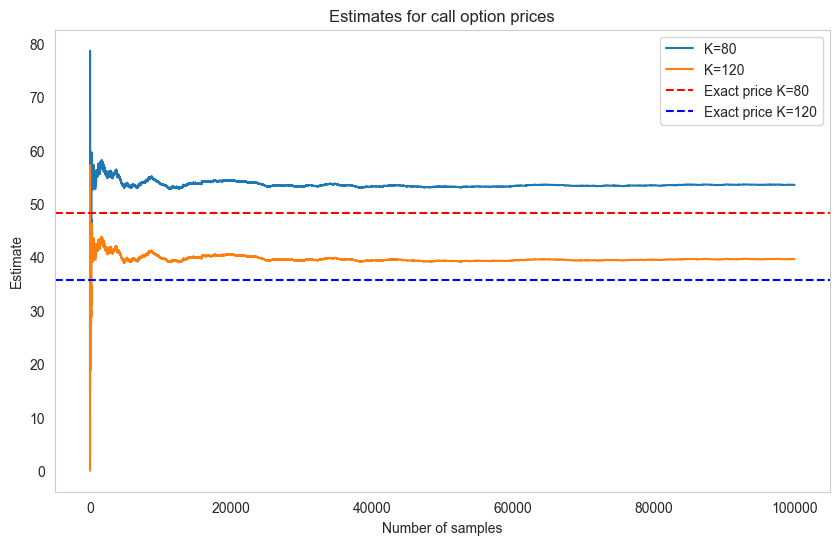

In [5]:
print("Plotting estimates")
plt.figure(figsize=(10, 6))
plt.plot(estimate_call_in_the_money, label=f"K={K_low}")
plt.plot(estimate_call_out_of_the_money, label=f"K={K_high}")
plt.axhline(call_in_the_money, color='red', linestyle='--', label=f"Exact price K={K_low}")
plt.axhline(call_out_of_the_money, color='blue', linestyle='--', label=f"Exact price K={K_high}")
plt.xlabel("Number of samples")
plt.ylabel("Estimate")
plt.title("Estimates for call option prices")
plt.legend()
plt.grid()
plt.show()

## 1a: Control variates
I take control variate
$$
e^{-rT} S_T
$$

In [6]:
n=100000
Z = np.random.normal(size=n)
S_T = S0 * np.exp(sigma * np.sqrt(T) * Z + (r - sigma**2 / 2) * T)
estimate_call_out_of_the_money = np.mean(np.maximum(S_T - K_high, 0))
estimate_call_in_the_money = np.mean(np.maximum(S_T - K_low, 0))
print(f"Estimate for K={K_low}: {estimate_call_in_the_money}")
print(f"Estimate for K={K_high}: {estimate_call_out_of_the_money}")

Estimate for K=80: 53.188662441750324
Estimate for K=120: 39.25023193915044
